<a href="https://colab.research.google.com/github/YagmurTaze/OCR-ICR/blob/main/3_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

from tqdm import tqdm

from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


## The Dataset

In [49]:
#import pandas as pd

# Excel dosyasını oku
#excel_file = '/content/validation.xlsx'
#df = pd.read_excel(excel_file)

# CSV olarak kaydet (UTF-8 kodlaması ile)
#csv_file = 'validation.csv'
#df.to_csv(csv_file, index=False, encoding='utf-8')

In [50]:
train = pd.read_csv('/content/train.csv')
valid = pd.read_csv('/content/validation.csv')

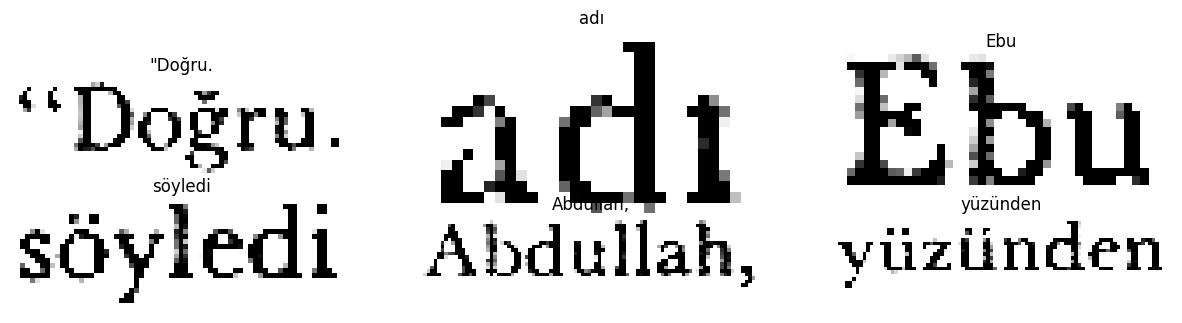

In [51]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/content/drive/MyDrive/Datasets/WORDS OCR/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [56]:
train_size = 7196
valid_size= 800

## Preprocess

In [53]:
def preprocess(img):
    (h, w) = img.shape

    final_img = np.ones([64, 256])*255 # blank white image

    # crop
    if w > 256:
        img = img[:, :256]

    if h > 64:
        img = img[:64, :]


    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [ ]:
train_x = []

for i in tqdm(range(train_size)):
    img_dir = '/content/drive/MyDrive/Datasets/WORDS OCR/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)

In [57]:
valid_x = []

for i in tqdm(range(valid_size)):
    img_dir = '/content/drive/MyDrive/Datasets/WORDS OCR/val/'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

100%|██████████| 800/800 [05:45<00:00,  2.31it/s]


In [58]:
len(valid_x)

800

In [59]:
# train_x listesini numpy array olarak kaydetme
train_x_array = np.array(train_x)
np.save('/content/drive/MyDrive/Datasets/WORDS OCR/train_x.npy', train_x_array)

# valid_x listesini numpy array olarak kaydetme
valid_x_array = np.array(valid_x)
np.save('/content/drive/MyDrive/Datasets/WORDS OCR/valid_x.npy', valid_x_array)

In [ ]:
# Kaydedilmiş numpy array dosyasını yükleme
train_x_array = np.load('/content/drive/MyDrive/Datasets/TURKISH WORDS/train_x.npy')
train_x = train_x_array.tolist()

valid_x_array = np.load('/content/drive/MyDrive/Datasets/TURKISH WORDS/valid_x.npy')
valid_x = valid_x_array.tolist()

## Part 2

In [108]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

In [109]:
alphabets = u"ABCÇDEFGĞHIİJKLMNOÖPRSŞTUÜVYZabcçdefgğhıijklmnoöprsştuüvyz0123456789\".,-':;()?/!+& "
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))

    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [110]:
name = 'ABC ?'
print(name, '\n',label_to_num(name))

ABC ? 
 [ 0  1  2 82 77]


In [111]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])

In [112]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])

In [113]:
print('True label : ',train.loc[100, 'IDENTITY'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100],
      '\ntrain_input_len : ', train_input_len[100])

True label :  istemiştir. 
train_y :  [40. 50. 52. 34. 44. 40. 51. 52. 40. 49. 69. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.] 
train_label_len :  [11.] 
train_input_len :  [62.]


## The Model

In [114]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 256, 64, 32)       320       
                                                                 
 batch_normalization_9 (Bat  (None, 256, 64, 32)       128       
 chNormalization)                                                
                                                                 
 activation_9 (Activation)   (None, 256, 64, 32)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 128, 32, 32)       0         
                                                                 
 conv2 (Conv2D)              (None, 128, 32, 64)       18496     
                                                           

In [115]:
# the ctc loss function
def ctc_lambda_func(args):
     y_pred, labels, input_length, label_length = args

     y_pred = y_pred[:, 2:, :]
     return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [116]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

## Training

In [117]:
metrics = ['accuracy']

model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate = 0.0001),metrics=metrics)

model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output,
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=50, batch_size=128)


Epoch 1/50
57/57 [==============================] - 14s 117ms/step - loss: 53.6361 - accuracy: 0.0000e+00 - val_loss: 32.6994 - val_accuracy: 0.0000e+00
Epoch 2/50
57/57 [==============================] - 5s 80ms/step - loss: 23.4886 - accuracy: 0.0000e+00 - val_loss: 24.0697 - val_accuracy: 0.0000e+00
Epoch 3/50
57/57 [==============================] - 4s 77ms/step - loss: 22.0332 - accuracy: 0.0000e+00 - val_loss: 22.2525 - val_accuracy: 0.0000e+00
Epoch 4/50
57/57 [==============================] - 4s 77ms/step - loss: 21.5114 - accuracy: 0.0000e+00 - val_loss: 21.7060 - val_accuracy: 0.0000e+00
Epoch 5/50
57/57 [==============================] - 4s 78ms/step - loss: 21.1869 - accuracy: 0.0000e+00 - val_loss: 21.4038 - val_accuracy: 0.0000e+00
Epoch 6/50
57/57 [==============================] - 4s 76ms/step - loss: 20.9684 - accuracy: 0.0000e+00 - val_loss: 21.0435 - val_accuracy: 0.0000e+00
Epoch 7/50
57/57 [==============================] - 4s 78ms/step - loss: 20.7776 - accuracy:

## Predict

In [118]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1],
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

25/25 [==============================] - 1s 7ms/step


In [119]:
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)

    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1

    if pr == tr :
        correct += 1

print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 68.04%
Correct words predicted      : 55.00%


In [120]:
model_final.save("wordModelOCR2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Predict 2

In [123]:
import cv2
import numpy as np
from keras.models import load_model, Model
from keras import backend as K
from keras.layers import Input

# Load the trained model
model = load_model("wordModelOCR2.h5", compile=False)

# Define the alphabet and other parameters
alphabets = u"ABCÇDEFGĞHIİJKLMNOÖPRSŞTUÜVYZabcçdefgğhıijklmnoöprsştuüvyz0123456789\".,-':;()?/!+& "
max_str_len = 24
num_of_timestamps = 64

def preprocess(img):
    (h, w) = img.shape
    final_img = np.ones([64, 256]) * 255  # blank white image

    # crop
    if w > 256:
        img = img[:, :256]
    if h > 64:
        img = img[:64, :]

    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret += alphabets[ch]
    return ret

# Create a new model that outputs predictions directly
input_data = Input(shape=(256, 64, 1), name='input')
y_pred = model.get_layer('softmax').output
prediction_model = Model(inputs=model.input[0], outputs=y_pred)

# Load and preprocess the new image
img_dir = '/content/word_14.png'
image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
image = preprocess(image)
image = image / 255.0

# Predict
pred = prediction_model.predict(image.reshape(1, 256, 64, 1))
decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0]) * pred.shape[1],
                                   greedy=True)[0][0])

print('Predicted text:', num_to_label(decoded[0]))


1/1 [==============================] - 1s 1s/step
Predicted text: Ancak,
